In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, cohen_kappa_score
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
from itertools import cycle
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set dataset directory (update this path accordingly)
dataset_dir = "/content/drive/My Drive/EEG/Model_Input"  # Change this to your extracted folder path

# Load participants.tsv
participants_file = os.path.join(dataset_dir, "/content/drive/My Drive/EEG/SET/participants.tsv")
participants_df = pd.read_csv(participants_file, sep="\t")

# Map participant_id to Group
participant_groups = dict(zip(participants_df["participant_id"], participants_df["Group"]))

In [ ]:
# Load and merge all CSV files
data_list = []
for file_name in os.listdir(dataset_dir):
    if file_name.startswith("dominating_frequencies") and file_name.endswith(".csv"):
        participant_id = f"sub-{file_name.split('frequencies')[-1].split('.')[0].zfill(3)}"
        file_path = os.path.join(dataset_dir, file_name)
        df = pd.read_csv(file_path)
        df["participant_id"] = participant_id
        df["Group"] = participant_groups.get(participant_id, None)
        data_list.append(df)

# Combine all data
full_data = pd.concat(data_list, ignore_index=True)


In [ ]:
# Encode categorical features
channel_encoder = LabelEncoder()
band_encoder = LabelEncoder()
group_encoder = LabelEncoder()

full_data["Channel"] = channel_encoder.fit_transform(full_data["Channel"])
full_data["Band"] = band_encoder.fit_transform(full_data["Band"])
full_data["Group"] = group_encoder.fit_transform(full_data["Group"])

In [ ]:
# Pivot data for model input
pivot_data = full_data.pivot_table(index="participant_id", columns=["Channel", "Band"],
                                   values=["Dominant Frequency (Hz)", "Power"], aggfunc="mean")
pivot_data.columns = [f"{col[0]}_Ch{col[1]}_Band{col[2]}" for col in pivot_data.columns]
pivot_data.reset_index(inplace=True)

# Merge with group labels
pivot_data = pivot_data.merge(participants_df[["participant_id", "Group"]], on="participant_id")
pivot_data.drop(columns=["participant_id"], inplace=True)

In [ ]:
# Split features and target
X = pivot_data.drop(columns=["Group"]).values
y = group_encoder.transform(pivot_data["Group"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build Neural Network Model
num_classes = max(y) + 1  # Ensure correct number of output classes
model = keras.Sequential([
    keras.layers.Dense(57, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(57*3, activation="relu"),
    keras.layers.Dense(57*9, activation="relu"),
    keras.layers.Dense(57*3, activation="relu"),
    keras.layers.Dense(57, activation="relu"),
    keras.layers.Dense(int (57/3), activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax")
])

# Compile Model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train Model
epoch=500
history = model.fit(X_train, y_train, epochs=epoch, validation_data=(X_test, y_test), verbose=1)

final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

Epoch 1/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step - accuracy: 0.2794 - loss: 2.7218 - val_accuracy: 0.4118 - val_loss: 2.0361
Epoch 2/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5044 - loss: 1.6113 - val_accuracy: 0.5882 - val_loss: 0.9378
Epoch 3/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3761 - loss: 1.2395 - val_accuracy: 0.5294 - val_loss: 0.9846
Epoch 4/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3909 - loss: 1.1184 - val_accuracy: 0.5882 - val_loss: 0.9343
Epoch 5/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5182 - loss: 1.0124 - val_accuracy: 0.2941 - val_loss: 1.1869
Epoch 6/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3440 - loss: 1.1443 - val_accuracy: 0.7059 - val_loss: 0.8858
Epoch 7/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5655 - loss: 0.9734 - val_accuracy: 0.6471 - val_loss: 0.8355
Epoch 8/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5064 - loss: 1.0236 - val_accuracy: 0.5882 - val_loss

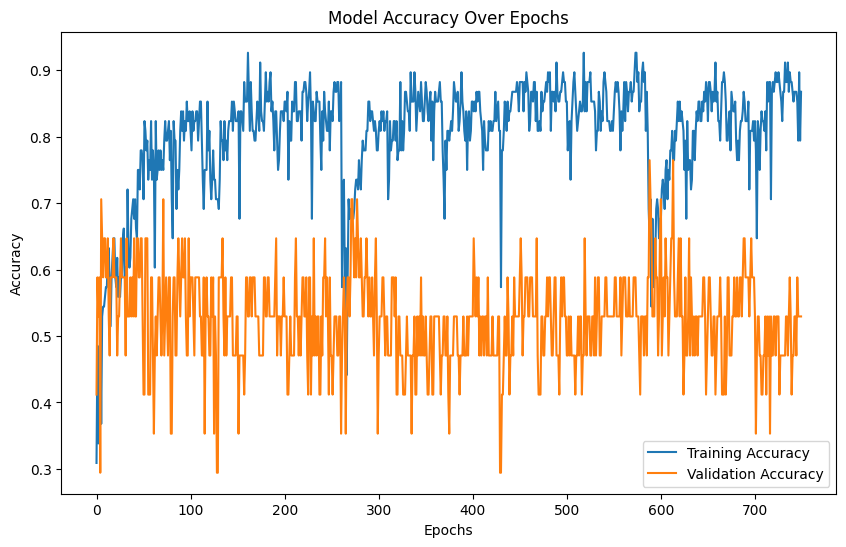

In [ ]:
# Plot accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Evaluate Model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute metrics
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=group_encoder.classes_)
kappa = cohen_kappa_score(y_test, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [ ]:
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)
print(f"Cohen Kappa Score: {kappa:.4f}")

Confusion Matrix:
 [[4 2 1]
 [1 4 0]
 [2 2 1]]
Classification Report:
               precision    recall  f1-score   support

           A       0.57      0.57      0.57         7
           C       0.50      0.80      0.62         5
           F       0.50      0.20      0.29         5

    accuracy                           0.53        17
   macro avg       0.52      0.52      0.49        17
weighted avg       0.53      0.53      0.50        17

Cohen Kappa Score: 0.2842


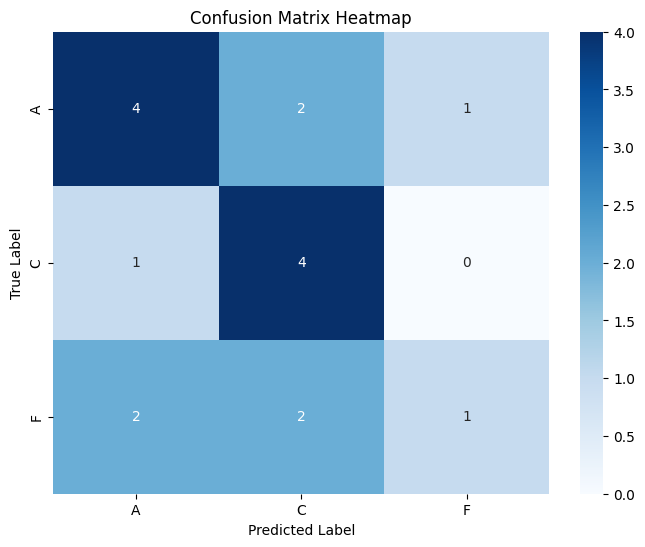

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=group_encoder.classes_, yticklabels=group_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [ ]:
# Sensitivity, Specificity, PPV, NPV
tn, fp, fn, tp = cm.ravel()[:4]  # Adjust for multi-class
sensitivity = float (tp / (tp + fn))
specificity = float (tn / (tn + fp))
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

In [ ]:
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

Sensitivity: 0.5000
Specificity: 0.6667
Positive Predictive Value: 0.3333
Negative Predictive Value: 0.8000


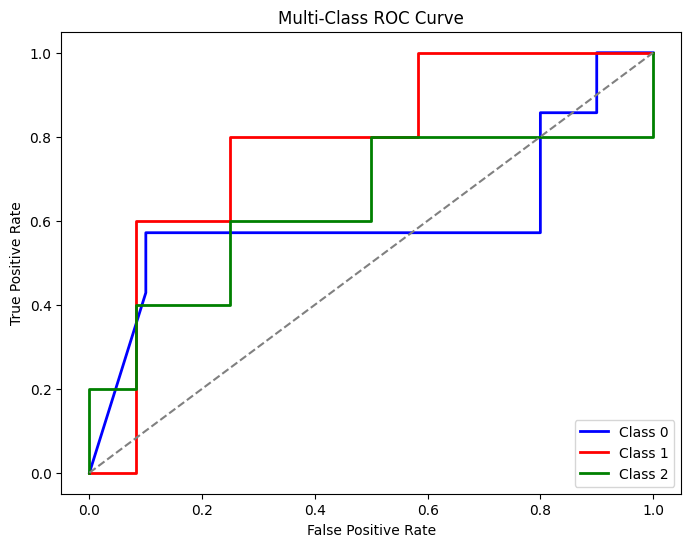

In [ ]:
# ROC Curve

num_classes = len(np.unique(y_test))  # Ensure correct class count
y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))

plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green", "orange", "purple"])  # For multiple classes

# Compute ROC curve for each class
for i, color in zip(range(num_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i}')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Graph Labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")

# Show plot
plt.show()

In [ ]:
# Store final weights and biases in a table
weights_biases = []
for i, layer in enumerate(model.layers):
    weights, biases = layer.get_weights()
    for j in range(weights.shape[1]):  # Ensure correct indexing
        weights_biases.append([f"Layer {i+1} - Node {j+1}", weights[:, j].tolist(), biases[j]])

weights_biases_df = pd.DataFrame(weights_biases, columns=["Node", "Weights", "Biases"])
weights_biases_df.to_csv(f"/content/drive/My Drive/EEG/SET/Weights and Bias/ANN13({epoch} epochs).csv", index=False)
print("Final weights and biases saved")

Final weights and biases saved
